In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load LLM

In [2]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.float16,
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## Generate time series

In [29]:
time_series_name = 'Brownian motion'

Nt = 1000 # number of steps
a = 0 # drift

# other hyper-parameters
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)
sigma = 0.8

random_seed = 7

np.random.seed(random_seed)
# Initialize the time series
x = 0  # Starting point
time_series = [x]
mean_series = [x]
sigma_series = [0]

# Generate the drift-diffusion time series
for t in range(1, Nt):
    x_mean = x + a*dt
    x_sigma = sigma * np.sqrt(dt)
    dW = np.random.normal()  # Wiener process (Brownian motion)
    x = x_mean + x_sigma * dW
    
    time_series.append(x)
    mean_series.append(x_mean)
    sigma_series.append(x_sigma)

## Define trainer and ICL

In [ ]:
from llmicl.interfaces import trainers  # import RLICLTrainer

# if you have modified the code since importing for the first time, reload will update the imported package
import importlib
importlib.reload(trainers)

In [30]:
context_length = 200
rescale_factor = 7.0
up_shift = 1.5

trainer = trainers.UnivariateICLTrainer(
    model=model,
    tokenizer=tokenizer,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=np.array(time_series), 
    mean_series=np.array(mean_series), 
    sigma_series=np.array(sigma_series), 
    context_length=context_length
)

trainer.icl()

icl_object = trainer.compute_statistics()

## Visualize

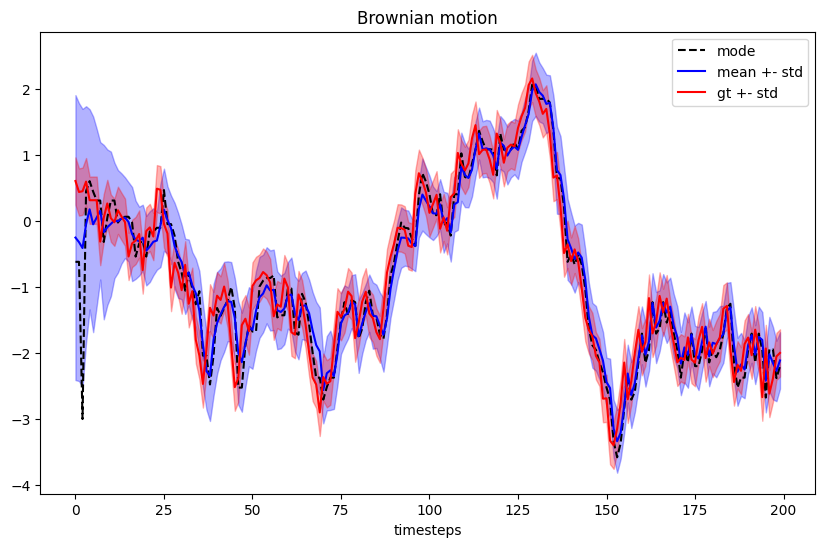

In [31]:
plt.figure(figsize=(10,6))
groundtruth = np.array(time_series[1:context_length+1])
gt_sigma = np.array(sigma_series[1:context_length+1])

ts_max = icl_object.rescaling_max
ts_min = icl_object.rescaling_min

mode_arr = ((icl_object.mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
mean_arr = ((icl_object.mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
sigma_arr = (icl_object.sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

x = np.arange(mean_arr.shape[0])

# ----------------- mode -----------------
plt.plot(x, mode_arr, 'k--',label='mode')

# ----------------- predicted mean +- std -----------------
plt.plot(x, mean_arr, label='mean +- std', color='blue')
plt.fill_between(x=x, y1=mean_arr-sigma_arr, y2=mean_arr+sigma_arr, color='blue', alpha=.3)

# ----------------- groundtruth mean +- std -----------------
plt.plot(x, groundtruth, label='gt +- std', color='red')
plt.fill_between(x=x, y1=groundtruth-gt_sigma, y2=groundtruth+gt_sigma, color='red', alpha=.3)

plt.title(f"{time_series_name}")
plt.xlabel("timesteps")
plt.legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()